Systematic Uncertainty Modelling
===

In the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, we left out the nuisance parameter piece of the parameterized density ratio decomposition:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_c(x)} = \prod_m \frac{p_c(x|\alpha_m^{eval})}{p_c(x)}$$

where the second equality assumes that **the effect of various sources of uncertainty in the model can be factorized**. This is another density ratio estimation problem, but instead of training m $\alpha-$parameterized NNs, we use a HistFactory-style interpolation generalized to a per-event formulation:

$$\frac{p_c(x|\alpha_m^{eval})}{p_c(x)} = \begin{cases}
    \left(\frac{p_c(x|\alpha_m^+)}{p_c(x)}\right)^{\alpha_m^\text{eval}}& \alpha_m^\text{eval}>1\\
    1+\sum_{n=1}^6c_n\cdot (\alpha_m^\text{eval})^n& -1\leq\alpha_m^\text{eval}\leq 1\\
    \left(\frac{p_c(x|\alpha_m^-)}{p_c(x)}\right)^{-\alpha_m^\text{eval}}& \alpha_m^\text{eval}<-1\\
    \end{cases}$$

where $\alpha=\{\alpha_m^{eval}\}$ and for each nuisance parameter $m$, we have three simulation models - $p_c(x), p_c(x|\alpha_m^+), p_c(x|\alpha_m^-)$. Naturally, this still requires NNs to estimate the density ratios:

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

**These are the density ratios that we will estimate using NNs in this notebook.**
Two ratios corresponding to each $\alpha_m^\pm$ will be trained for each systematic uncertainty indexed by $m$ and for each channel $c$ to build the final parameterized model, 

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

The full workflow for building $\mu, \alpha-$parameterized density ratios is represented in the flowchart below:

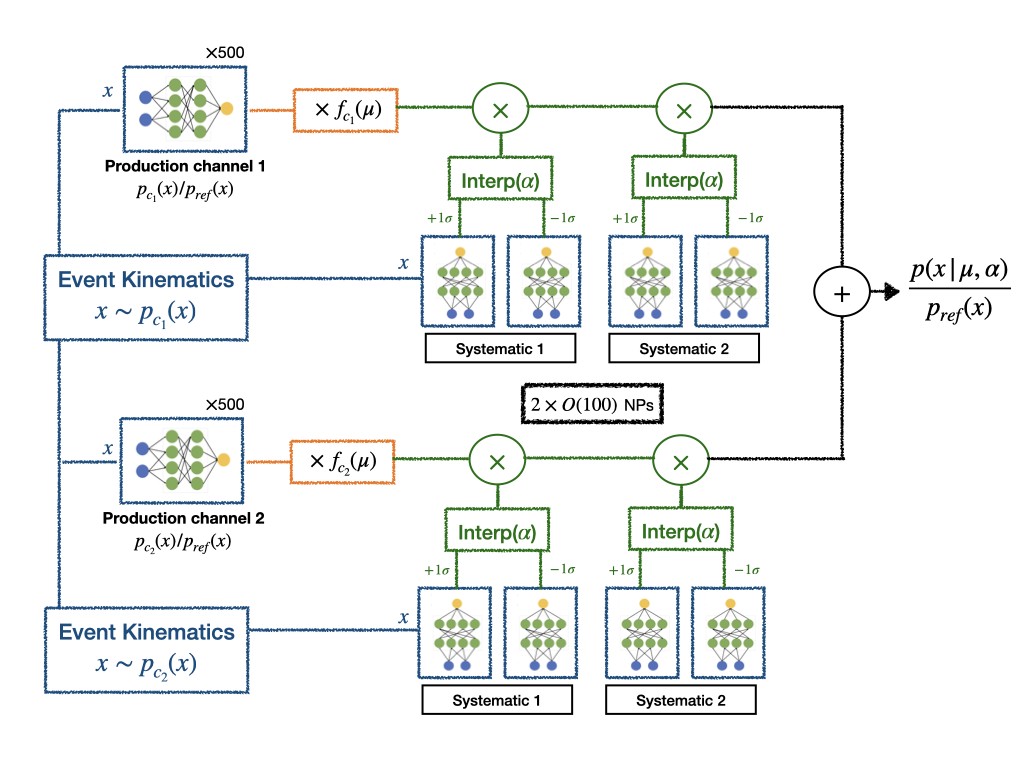

In [1]:
import os, sys, importlib
# sys.path.append('/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/')

import nsbi_common_utils
from nsbi_common_utils import plotting, training
from nsbi_common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN

from utils import calculate_preselection_observable, preselection_using_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle
import yaml
import random
import numpy as np

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

/data/jaySandesara/NSBI_workflow_tutorial/src/nsbi_common_utils/plotting.py:11: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-07-04 18:29:47.885154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751653787.900926 1211061 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751653787.905226 1211061 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-04 18:29:47.924631: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instr

In [2]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

In [3]:
# path prefix for general save directory
path_prefix = config['path_prefix']

# sub-path for saving cached data used between modules
path_saved_data = config['path_saved_data']
saved_data = f'{path_prefix}{path_saved_data}'

# Path for loading preselection NN model
path_preselection_NN_model = config['path_preselection_NN_model']
path_to_saved_presel_model = f'{path_prefix}{path_preselection_NN_model}'

# Input features for training
features = config["features"]

channels_binned = config["channels_binned"]

# Subset of the features to standardize before training
features_scaling = config["features_scaling"]

# Get the dictionary of labels to processes
labels_dict = config["labels_dict"]

# Signal processes in the model
signal_processes = config["signal_processes"]

# Background processes in the model
background_processes = config["background_processes"]

mix_model_hypotheses = config["mix_model_hypotheses"]
ref_processes = config["ref_processes"]

# float factors multiplying the probabilities in the preselection score observable 
pre_factor_preselection_score = config["pre_factor_preselection_score"]


In [4]:
dict_systs = config["dict_systs"]
print(dict_systs)

{'TES': {'process': ['htautau', 'ttbar', 'ztautau'], 'directions': ['up', 'dn']}, 'JES': {'process': ['htautau', 'ttbar', 'ztautau'], 'directions': ['up', 'dn']}}


In [5]:
# Load the datasets corresponding to systematic variations
datasets_syst = {}

for syst in dict_systs:

    datasets_syst[syst] = {}

    for direction in dict_systs[syst]['directions']:

        datasets_syst[syst][direction] = pd.read_hdf(f"{saved_data}df_{syst}_{direction}.h5", key="dataset")


dataset_nom = pd.read_hdf(f"{saved_data}df_nominal.h5", key="dataset")

pred_NN_incl_nom = np.load(f"{saved_data}pred_NN_incl.npy")
presel_score_nom = calculate_preselection_observable(pred_NN_incl_nom, 
                                                     labels_dict, signal_processes, 
                                                     background_processes, 
                                                     pre_factor_dict = pre_factor_preselection_score)

dataset_nom['presel_score'] = presel_score_nom

list_syst = [key for key in dict_systs]
print(list_syst)

['TES', 'JES']


In [6]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluatePreselNN

num_classes = len(labels_dict)

for syst in datasets_syst:

    for direction in datasets_syst[syst]:

        # Skip preselection score calculation if already done in a previous round
        if 'presel_score' in list(datasets_syst[syst][direction].columns): continue

        dataset = datasets_syst[syst][direction]
    
        preselectionTraining = TrainEvaluatePreselNN(dataset, num_classes, features, features_scaling)
        preselectionTraining.get_trained_model(path_to_saved_presel_model)
        pred_NN_incl = preselectionTraining.predict(dataset)

        presel_score = calculate_preselection_observable(pred_NN_incl, labels_dict, 
                                                         signal_processes, background_processes)

        datasets_syst[syst][direction]['presel_score'] = presel_score

        # Overwrite saved dataframe with preselection score saved for future iterations
        datasets_syst[syst][direction].to_hdf(f"{saved_data}df_{syst}_{direction}.h5", key="dataset", mode="w")

        del dataset, presel_score, pred_NN_incl
        

In [7]:
preselection_cuts = np.load(f"{saved_data}preselection_cuts.npy", allow_pickle=True).item()

channel_selections = {'CR': {'observable': 'presel_score', 
                             'lower_presel': -999, 
                             'upper_presel': preselection_cuts.get('lower'), 
                             'num_bins': 4},
                      'SR_binned': {'observable': 'presel_score', 
                                    'lower_presel': preselection_cuts.get('upper'), 
                                    'upper_presel': -999,
                                    'num_bins': 2},
                      'SR': {'observable': None, 
                             'upper_presel': preselection_cuts.get('upper'), 
                             'lower_presel': preselection_cuts.get('lower')}}


dataset_nom_channels = preselection_using_score(dataset_nom, channel_selections)

datasets_syst_channels = {}
    
for syst in datasets_syst:

    datasets_syst_channels[syst] = {}
    
    for direction in datasets_syst[syst]:

        datasets_syst_channels[syst][direction] = preselection_using_score(datasets_syst[syst][direction], 
                                                                           channel_selections)


del dataset_nom, datasets_syst

Signal and Control Regions
===

The SR needs additional density ratios to be trained, whereas the CR follows the standard procedure of template histogram building.

In [8]:
hist_binned = {}
bins = {}
min_presel_bin = {}
max_presel_bin = {}
observable = {}

for channel, dict_observable in channel_selections.items():

    fit_observable = channel_selections[channel]['observable']
    if fit_observable == None: continue
    
    with open(f"{saved_data}hist_binned_{channel}.pkl", "rb") as fp:
        hist_binned[channel] = pickle.load(fp)

    bins[channel] = np.load(f"{saved_data}bins_{channel}.npy")
    observable[channel] = fit_observable

    min_presel_bin[channel] = bins[channel][0]
    max_presel_bin[channel] = bins[channel][-1]

In [9]:
hist_var = {}

for channel, dict_observable in channel_selections.items():

    if channel not in channels_binned: continue

    hist_var[channel] = {}
    
    for process in labels_dict:
        
        hist_var[channel][process] = {}
        
        for syst in dict_systs:
    
            hist_var[channel][process][syst] = {}
    
            for direction in ['up','dn']:
    
                hist_var[channel][process][syst][direction] = {}
                
                mask_process = (datasets_syst_channels[syst][direction][channel].type==process)
            
                if (process not in dict_systs[syst]['process']) | (direction not in dict_systs[syst]['directions']):
                    hist_var[channel][process][syst][direction] = np.ones_like(hist_CR[process])
    
                else:
    
                    dataset_process = datasets_syst_channels[syst][direction][channel][mask_process].copy()
                    
                    hist_var[channel][process][syst][direction] = np.histogram(np.clip(dataset_process[observable[channel]].ravel(), 
                                                                        min_presel_bin[channel], max_presel_bin[channel]), 
                                                                        weights = dataset_process['weights'].ravel(),
                                                                        bins = bins[channel])[0]/hist_binned[channel][process]
    
                    del dataset_process
    

In [10]:
# Save the Control Region variation histogram
with open(f"{saved_data}hist_binned_variations.pkl", "wb") as fp:
    pickle.dump(hist_var, fp)

Density ratio training
===

Now we train the NNs to predict two ratios,

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

for each nuisance parameter $\alpha_m$, for each process $p_c$ that is affected by the corresponding nuisance parameter.

Here is a major computational bottleneck of this workflow - for $N_{syst}$ systematics affecting each of the $N_{proc}$ processes, we would need a total of 

$$N_{syst} \times N_{proc} \times 2$$

well-trained NNs. In our example with $N_{syst}=2$ and $N_{proc}=3$, this corresponds to a total of 12 NNs. Typically in LHC experiments $N_{syst}\approx O(10^2)$! This type of approach thus requires a GPU infrastructure for efficient optimizations.

In [11]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluate_NN

ref_processes = np.load(f"{saved_data}ref_processes.npy")

dataset_syst_process = {}
NN_training_syst_process = {}

# rnd_seed_traintestsplit = 42 # can also be randomized, fixed for now
rnd_seed_traintestsplit = random.randint(0, 2**32 - 1)

DELETE_EXISTING_MODELS = True
# DELETE_EXISTING_MODELS = False


for process in labels_dict:
    
    NN_training_syst_process[process] = {}

    mask_process_nom = (dataset_nom_channels['SR'].type==process)
    dataset_den = dataset_nom_channels['SR'][mask_process_nom].copy()
    
    for syst in dict_systs:

        if process not in dict_systs[syst]['process']:
            print(f"Nothing to train for {process} in {syst} uncertainty")
            continue
        
        NN_training_syst_process[process][syst] = {}
        
        for direction in dict_systs[syst]['directions']:

            mask_process_syst = (datasets_syst_channels[syst][direction]['SR'].type==process)
            
            # Save paths
            top_path = f'{path_prefix}output_training_systematics/'

            output_name = f'{process}_{syst}_{direction}'
            output_dir = f'{top_path}general_output_{process}_{syst}_{direction}'
            path_to_ratios = f'{top_path}output_ratios_{process}_{syst}_{direction}/'
            path_to_figures = f'{top_path}output_figures_{process}_{syst}_{direction}/'
            path_to_models = f'{top_path}output_model_params_{process}_{syst}_{direction}/'

            dataset_num = datasets_syst_channels[syst][direction]['SR'][mask_process_syst].copy()

            dataset_num['train_labels'] = 1
            dataset_den['train_labels'] = 0

            dataset_num['weights_normed'] = dataset_num['weights'].to_numpy() / dataset_num['weights'].sum()
            dataset_den['weights_normed'] = dataset_den['weights'].to_numpy() / dataset_den['weights'].sum()
            
            # Build a training dataset for the training of p_<process_type>/p_<ref_processes> density ratio
            dataset_syst_process = pd.concat([dataset_num, dataset_den])

            
            NN_training_syst_process[process][syst][direction] = TrainEvaluate_NN(dataset_syst_process, 
                                                                                   dataset_syst_process['weights_normed'].to_numpy(),
                                                                                   dataset_syst_process['train_labels'].to_numpy(),
                                                                                   features, 
                                                                                   features_scaling,
                                                                                   [syst+'_'+direction, process], 
                                                                                  output_dir, output_name, 
                                                                                    path_to_figures=path_to_figures,
                                                                                    path_to_ratios=path_to_ratios, 
                                                                                    path_to_models=path_to_models,
                                                                                    delete_existing_models = DELETE_EXISTING_MODELS)

    del dataset_num, dataset_den
                




 Training for TES systematic for process htautau 


starting ensemble training
Sum of weights of class 0: 0.7000006437301636
Sum of weights of class 1: 0.7000006437301636
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751653811.457785 1211061 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3234 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:c1:00.0, compute capability: 8.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100


I0000 00:00:1751653813.568667 1211483 service.cc:148] XLA service 0x7f993c003b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751653813.568724 1211483 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.5gb, Compute Capability 8.0
2025-07-04 18:30:13.656338: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751653813.785783 1211483 cuda_dnn.cc:529] Loaded cuDNN version 90501


  4/161 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - binary_accuracy: 0.5018 - loss: 5.4457e-07

I0000 00:00:1751653814.282900 1211483 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.5041 - loss: 5.4453e-07

2025-07-04 18:30:18.537129: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_2', 4 bytes spill stores, 4 bytes spill loads



161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - binary_accuracy: 0.5041 - loss: 5.4453e-07 - val_binary_accuracy: 0.5040 - val_loss: 5.4450e-07 - learning_rate: 0.1000
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5072 - loss: 5.4447e-07 - val_binary_accuracy: 0.5045 - val_loss: 5.4448e-07 - learning_rate: 0.1000
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5083 - loss: 5.4442e-07 - val_binary_accuracy: 0.5084 - val_loss: 5.4442e-07 - learning_rate: 0.1000
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5101 - loss: 5.4438e-07 - val_binary_accuracy: 0.5093 - val_loss: 5.4439e-07 - learning_rate: 0.1000
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5105 - loss: 5.4435e-07 - val_binary_accuracy: 0.5093 - val_loss: 5.4436e-07 - learning_rate: 0.1000
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5110 - loss: 5.4431e-07 - val_binary_accuracy: 0.5096 - v

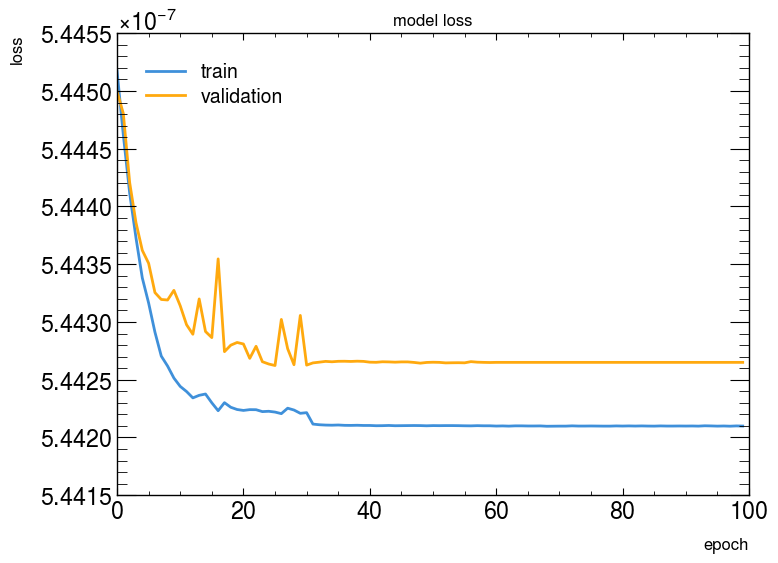

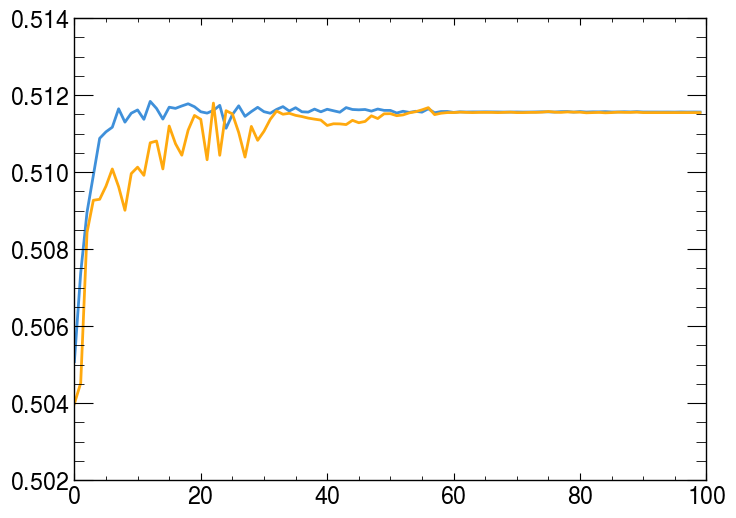

179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step



The sum of PDFs in ensemble member 0 is 0.9991428521481199


The sum of PDFs using the whole ensemble is 0.9991428521481199



starting ensemble training
Sum of weights of class 0: 0.7000002264976501
Sum of weights of class 1: 0.6999995708465576
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.5022 - loss: 5.4845e-07

2025-07-04 18:37:09.811244: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_2', 4 bytes spill stores, 4 bytes spill loads



160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - binary_accuracy: 0.5022 - loss: 5.4845e-07 - val_binary_accuracy: 0.5075 - val_loss: 5.4838e-07 - learning_rate: 0.1000
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5067 - loss: 5.4837e-07 - val_binary_accuracy: 0.5103 - val_loss: 5.4833e-07 - learning_rate: 0.1000
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5089 - loss: 5.4833e-07 - val_binary_accuracy: 0.5106 - val_loss: 5.4828e-07 - learning_rate: 0.1000
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - binary_accuracy: 0.5105 - loss: 5.4827e-07 - val_binary_accuracy: 0.5107 - val_loss: 5.4825e-07 - learning_rate: 0.1000
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5108 - loss: 5.4824e-07 - val_binary_accuracy: 0.5110 - val_loss: 5.4820e-07 - learning_rate: 0.1000
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5115 - loss: 5.4820e-07 - val_binary_accuracy: 0.5121 - v

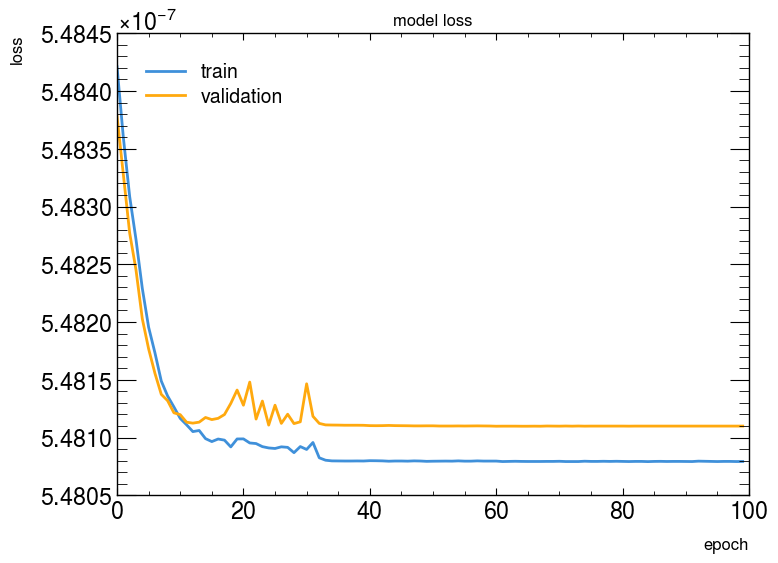

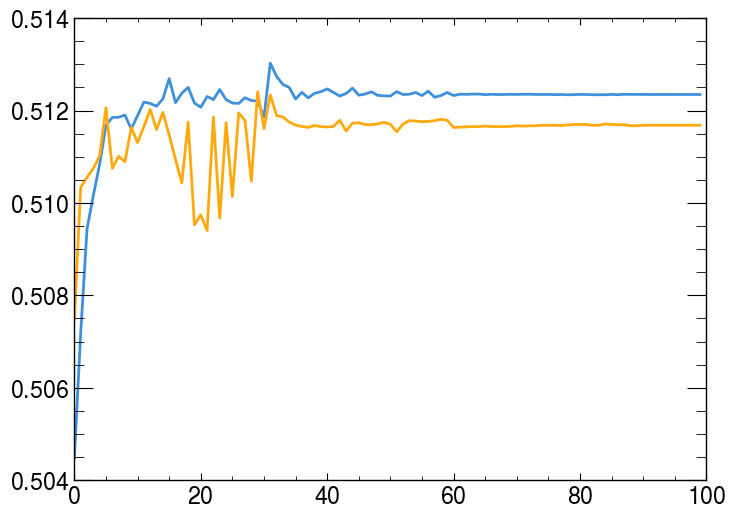

177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step



The sum of PDFs in ensemble member 0 is 0.9998129511461683


The sum of PDFs using the whole ensemble is 0.9998129511461683





 Training for JES systematic for process htautau 


starting ensemble training
Sum of weights of class 0: 0.7000003457069397
Sum of weights of class 1: 0.7000013589859009
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - binary_accuracy: 0.5011 - loss: 5.4597e-07 - val_binary_accuracy: 0.5012 - val_loss: 5.4597e-07 - learning_rate: 0.1000
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5047 - loss: 5.4593e-07 - val_binary_accuracy: 0.5030 - val_loss: 5.4596e-07 - learning_rate: 0.1000
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5049 - loss: 5.4592e-07 - val_binary_accuracy: 0.5052 - val_loss: 5.4596e-07 - learning_rate: 0.1000
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5055 - loss: 5.4592e-07 - val_binary_accuracy: 0.5029 - val_loss: 5.4595e-07 - learning_rate: 0.1000
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5059 - loss: 5.4590e-07 - val_binary_accuracy: 0.5047 - val_loss: 5.4594e-07 - learning_rate: 0.1000
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5061 - loss: 5.4590e-07 - val

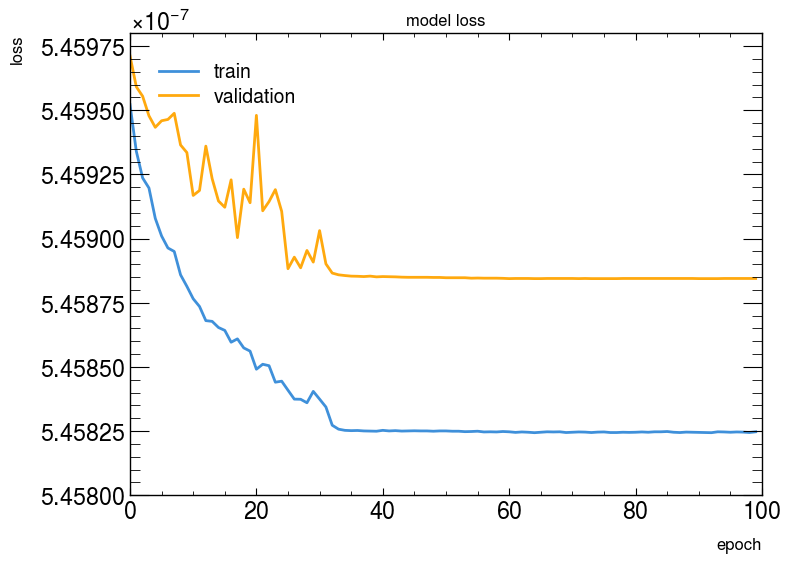

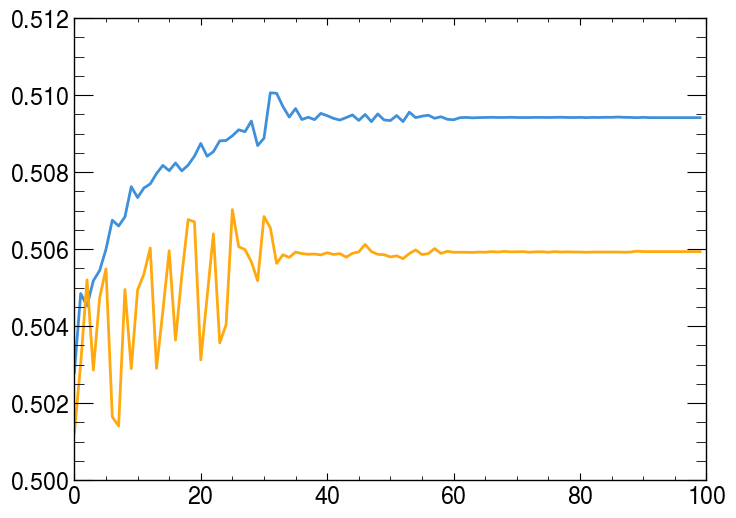

178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step



The sum of PDFs in ensemble member 0 is 0.9998853688938361


The sum of PDFs using the whole ensemble is 0.9998853688938361



starting ensemble training
Sum of weights of class 0: 0.7000002861022949
Sum of weights of class 1: 0.6999990940093994
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - binary_accuracy: 0.5026 - loss: 5.4713e-07 - val_binary_accuracy: 0.5037 - val_loss: 5.4710e-07 - learning_rate: 0.1000
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5054 - loss: 5.4709e-07 - val_binary_accuracy: 0.5026 - val_loss: 5.4712e-07 - learning_rate: 0.1000
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5044 - loss: 5.4710e-07 - val_binary_accuracy: 0.5031 - val_loss: 5.4710e-07 - learning_rate: 0.1000
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5051 - loss: 5.4708e-07 - val_binary_accuracy: 0.5041 - val_loss: 5.4708e-07 - learning_rate: 0.1000
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5050 - loss: 5.4709e-07 - val_binary_accuracy: 0.5066 - val_loss: 5.4707e-07 - learning_rate: 0.1000
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - binary_accuracy: 0.5065 - loss: 5.4706e-07 - val

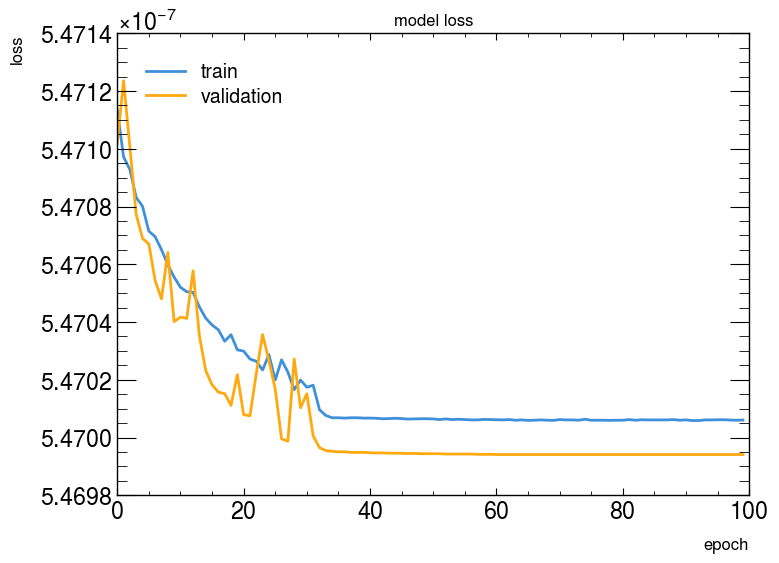

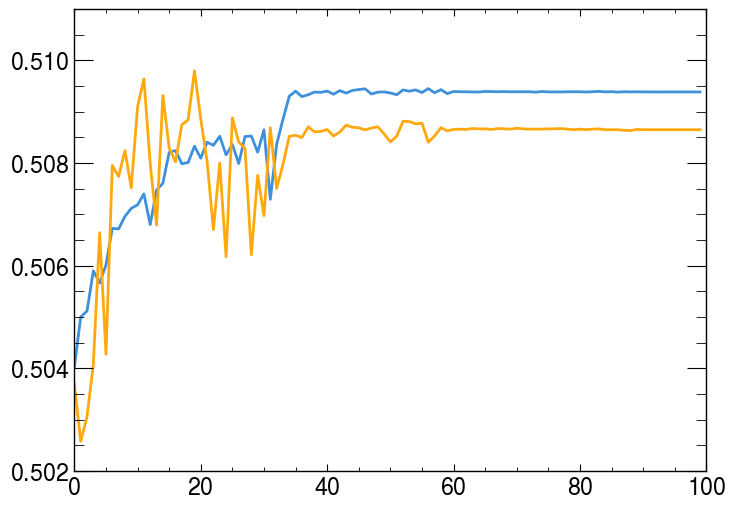

178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step



The sum of PDFs in ensemble member 0 is 0.9998080828536114


The sum of PDFs using the whole ensemble is 0.9998080828536114





 Training for TES systematic for process ztautau 


starting ensemble training
Sum of weights of class 0: 0.7000010013580322
Sum of weights of class 1: 0.6999990940093994
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - binary_accuracy: 0.5060 - loss: 1.3118e-06 - val_binary_accuracy: 0.5070 - val_loss: 1.3115e-06 - learning_rate: 0.1000
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5097 - loss: 1.3116e-06 - val_binary_accuracy: 0.5114 - val_loss: 1.3111e-06 - learning_rate: 0.1000
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5117 - loss: 1.3113e-06 - val_binary_accuracy: 0.5117 - val_loss: 1.3109e-06 - learning_rate: 0.1000
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - binary_accuracy: 0.5133 - loss: 1.3111e-06 - val_binary_accuracy: 0.5180 - val_loss: 1.3106e-06 - learning_rate: 0.1000
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5148 - loss: 1.3110e-06 - val_binary_accuracy: 0.5179 - val_loss: 1.3105e-06 - learning_rate: 0.1000
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5161 - loss: 1.3108e-06 - val_binary_accu

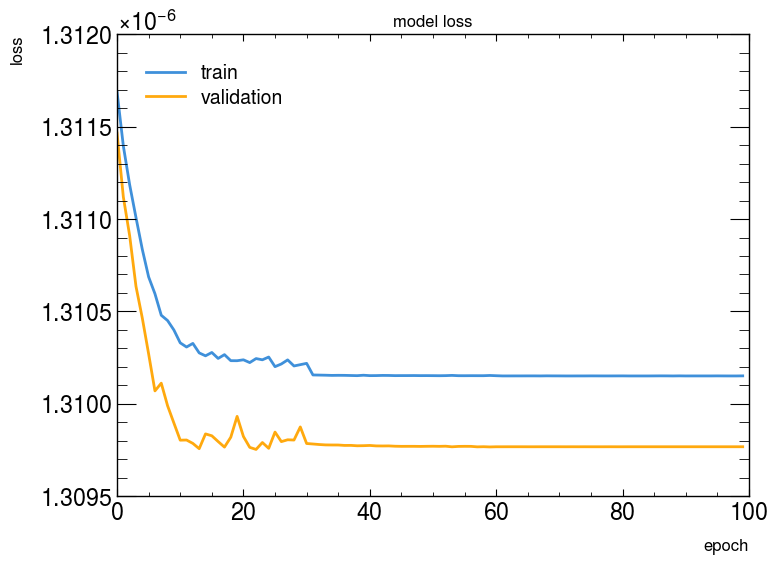

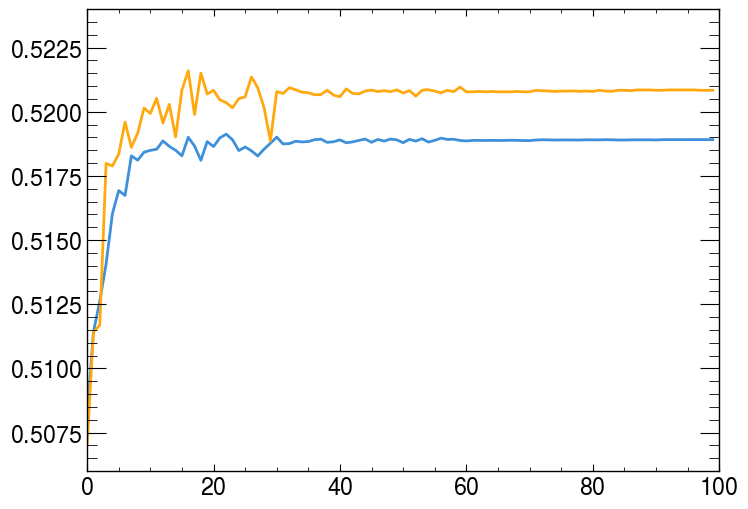

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step



The sum of PDFs in ensemble member 0 is 0.9997343207831411


The sum of PDFs using the whole ensemble is 0.9997343207831411



starting ensemble training
Sum of weights of class 0: 0.6999990940093994
Sum of weights of class 1: 0.7000010013580322
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - binary_accuracy: 0.5033 - loss: 1.3848e-06 - val_binary_accuracy: 0.5113 - val_loss: 1.3842e-06 - learning_rate: 0.1000
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5118 - loss: 1.3843e-06 - val_binary_accuracy: 0.5123 - val_loss: 1.3840e-06 - learning_rate: 0.1000
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5132 - loss: 1.3840e-06 - val_binary_accuracy: 0.5153 - val_loss: 1.3838e-06 - learning_rate: 0.1000
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5152 - loss: 1.3837e-06 - val_binary_accuracy: 0.5170 - val_loss: 1.3835e-06 - learning_rate: 0.1000
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5177 - loss: 1.3836e-06 - val_binary_accuracy: 0.5148 - val_loss: 1.3832e-06 - learning_rate: 0.1000
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5190 - loss: 1.3832e-06 - val_binary_accu

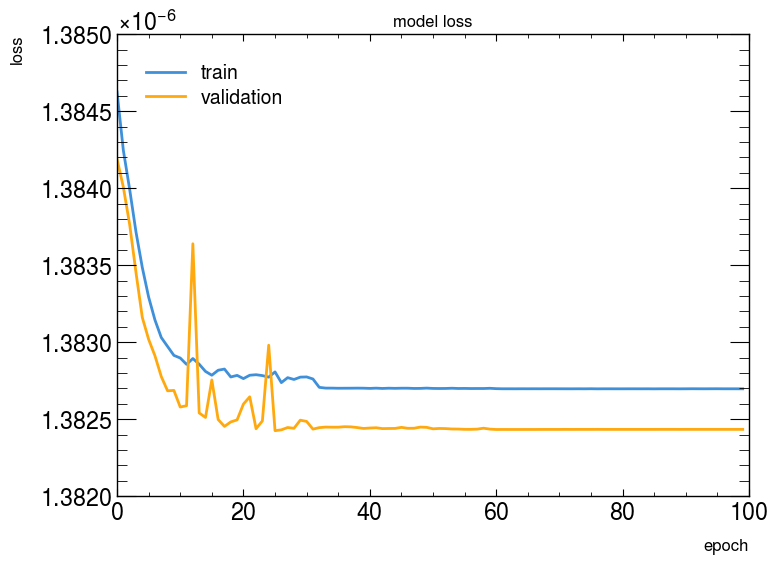

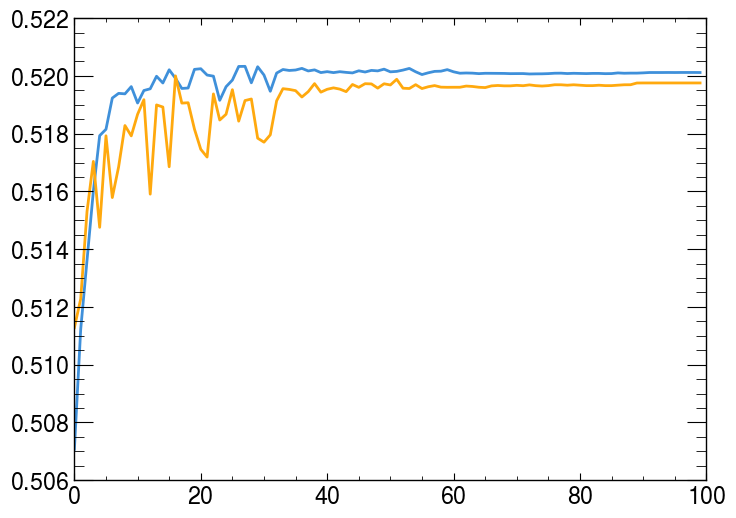

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step



The sum of PDFs in ensemble member 0 is 1.000674427803437


The sum of PDFs using the whole ensemble is 1.000674427803437





 Training for JES systematic for process ztautau 


starting ensemble training
Sum of weights of class 0: 0.6999990940093994
Sum of weights of class 1: 0.7000010013580322
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - binary_accuracy: 0.5013 - loss: 1.3339e-06 - val_binary_accuracy: 0.5097 - val_loss: 1.3335e-06 - learning_rate: 0.1000
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5063 - loss: 1.3337e-06 - val_binary_accuracy: 0.5082 - val_loss: 1.3334e-06 - learning_rate: 0.1000
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5068 - loss: 1.3336e-06 - val_binary_accuracy: 0.5065 - val_loss: 1.3334e-06 - learning_rate: 0.1000
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5051 - loss: 1.3336e-06 - val_binary_accuracy: 0.5084 - val_loss: 1.3334e-06 - learning_rate: 0.1000
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5070 - loss: 1.3336e-06 - val_binary_accuracy: 0.5099 - val_loss: 1.3334e-06 - learning_rate: 0.1000
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5081 - loss: 1.3336e-06 - val_binary_accu

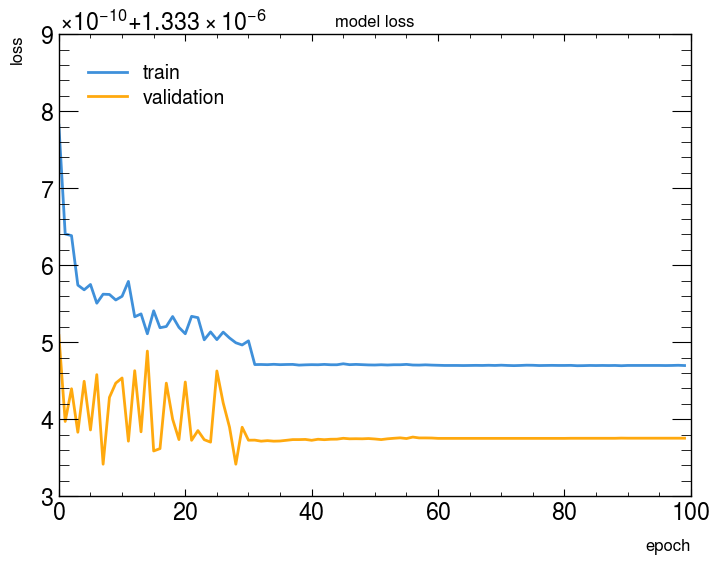

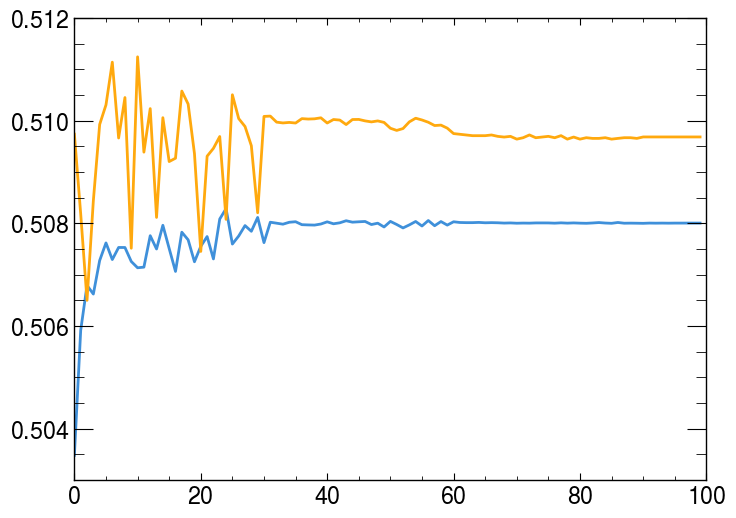

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step



The sum of PDFs in ensemble member 0 is 0.9997083782966738


The sum of PDFs using the whole ensemble is 0.9997083782966738



starting ensemble training
Sum of weights of class 0: 0.6999990940093994
Sum of weights of class 1: 0.7000009417533875
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - binary_accuracy: 0.5019 - loss: 1.3631e-06

2025-07-04 19:07:30.445855: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_2', 4 bytes spill stores, 4 bytes spill loads



65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - binary_accuracy: 0.5019 - loss: 1.3631e-06 - val_binary_accuracy: 0.5020 - val_loss: 1.3632e-06 - learning_rate: 0.1000
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - binary_accuracy: 0.5064 - loss: 1.3628e-06 - val_binary_accuracy: 0.5030 - val_loss: 1.3630e-06 - learning_rate: 0.1000
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5057 - loss: 1.3628e-06 - val_binary_accuracy: 0.5092 - val_loss: 1.3628e-06 - learning_rate: 0.1000
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5073 - loss: 1.3628e-06 - val_binary_accuracy: 0.5010 - val_loss: 1.3633e-06 - learning_rate: 0.1000
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5066 - loss: 1.3628e-06 - val_binary_accuracy: 0.5026 - val_loss: 1.3630e-06 - learning_rate: 0.1000
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5075 - loss: 1.3629e-06 - val_binary_accuracy: 0.5034 - val_loss: 1.3

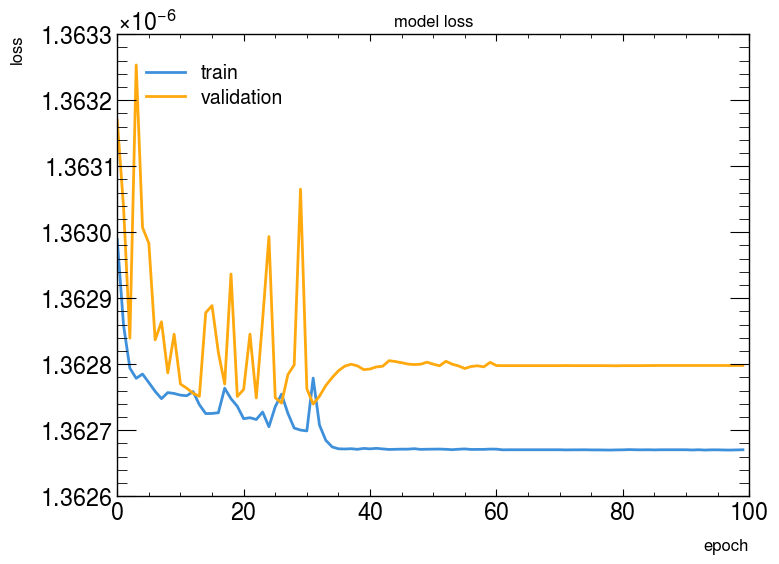

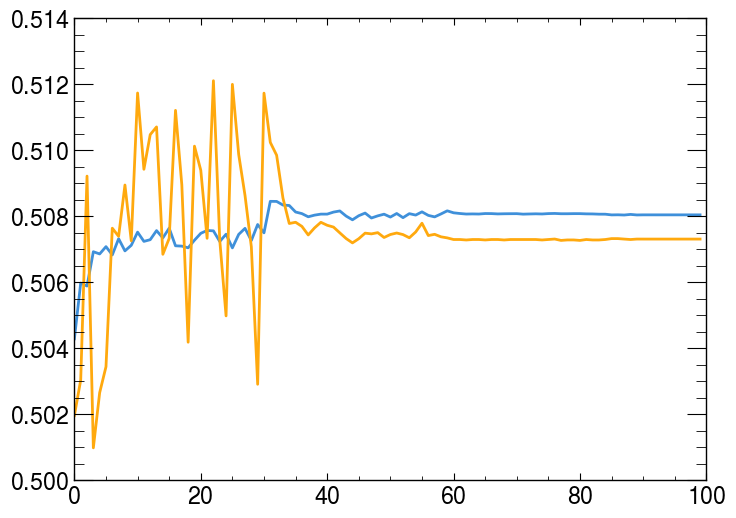

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step



The sum of PDFs in ensemble member 0 is 0.9985192016183699


The sum of PDFs using the whole ensemble is 0.9985192016183699





 Training for TES systematic for process ttbar 


starting ensemble training
Sum of weights of class 0: 0.7000027298927307
Sum of weights of class 1: 0.7000014781951904
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - binary_accuracy: 0.4993 - loss: 3.8072e-06 - val_binary_accuracy: 0.4998 - val_loss: 3.8071e-06 - learning_rate: 0.1000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5001 - loss: 3.8067e-06 - val_binary_accuracy: 0.5034 - val_loss: 3.8063e-06 - learning_rate: 0.1000
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.5049 - loss: 3.8061e-06 - val_binary_accuracy: 0.5013 - val_loss: 3.8062e-06 - learning_rate: 0.1000
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5041 - loss: 3.8061e-06 - val_binary_accuracy: 0.5048 - val_loss: 3.8062e-06 - learning_rate: 0.1000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.5053 - loss: 3.8060e-06 - val_binary_accuracy: 0.5026 - val_loss: 3.8061e-06 - learning_rate: 0.1000
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5060 - loss: 3.8060e-06 - val_binary_accu

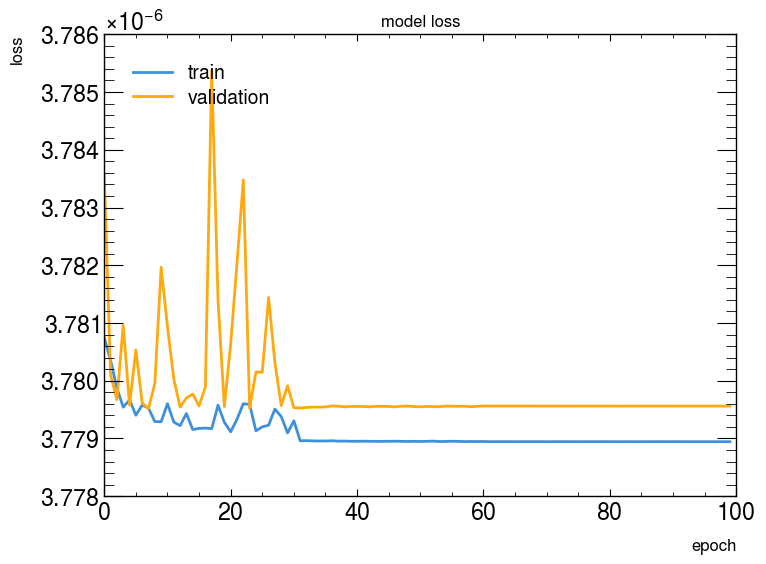

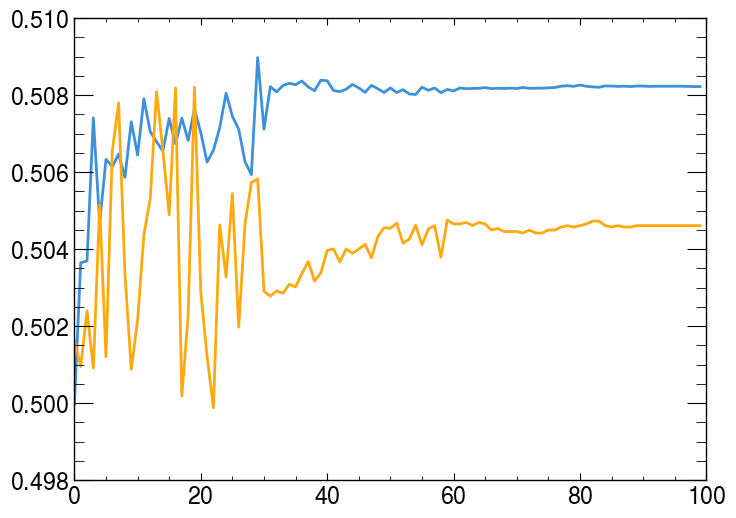

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step



The sum of PDFs in ensemble member 0 is 0.999044468855578


The sum of PDFs using the whole ensemble is 0.999044468855578





 Training for JES systematic for process ttbar 


starting ensemble training
Sum of weights of class 0: 0.7000125050544739
Sum of weights of class 1: 0.6999968886375427
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - binary_accuracy: 0.5039 - loss: 3.8020e-06 - val_binary_accuracy: 0.5045 - val_loss: 3.8033e-06 - learning_rate: 0.1000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.5055 - loss: 3.8020e-06 - val_binary_accuracy: 0.5063 - val_loss: 3.8031e-06 - learning_rate: 0.1000
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.5069 - loss: 3.8015e-06 - val_binary_accuracy: 0.5052 - val_loss: 3.8026e-06 - learning_rate: 0.1000
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5076 - loss: 3.8012e-06 - val_binary_accuracy: 0.5003 - val_loss: 3.8031e-06 - learning_rate: 0.1000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - binary_accuracy: 0.5076 - loss: 3.8013e-06 - val_binary_accuracy: 0.5065 - val_loss: 3.8025e-06 - learning_rate: 0.1000
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - binary_accuracy: 0.5072 - loss: 3.8014e-06 - val_binary_accu

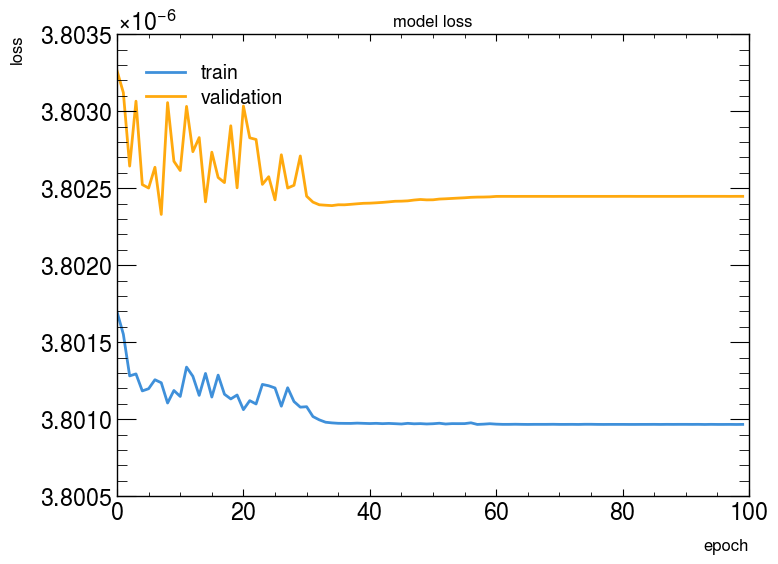

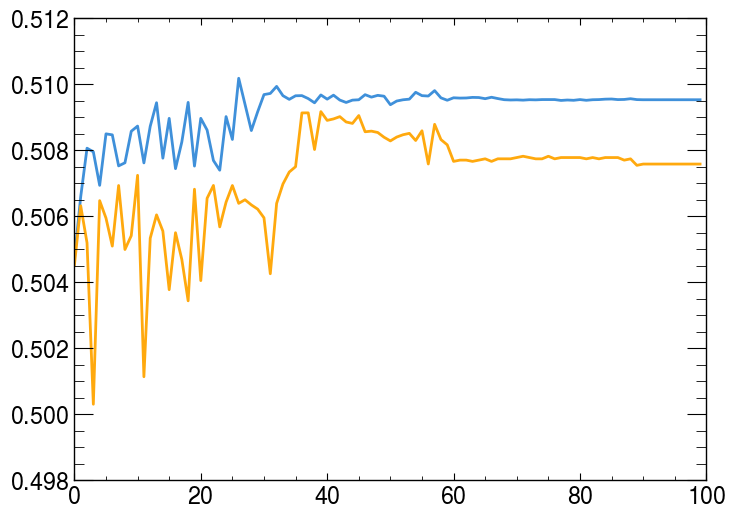

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step



The sum of PDFs in ensemble member 0 is 1.0003641259348914


The sum of PDFs using the whole ensemble is 1.0003641259348914



starting ensemble training
Sum of weights of class 0: 0.7000077366828918
Sum of weights of class 1: 0.699996829032898
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,001 (11.49 MB)

 Trainable params: 3,013,001 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - binary_accuracy: 0.5012 - loss: 3.7849e-06 - val_binary_accuracy: 0.5029 - val_loss: 3.7844e-06 - learning_rate: 0.1000
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.5076 - loss: 3.7846e-06 - val_binary_accuracy: 0.5033 - val_loss: 3.7846e-06 - learning_rate: 0.1000
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.5054 - loss: 3.7844e-06 - val_binary_accuracy: 0.5077 - val_loss: 3.7839e-06 - learning_rate: 0.1000
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.5083 - loss: 3.7842e-06 - val_binary_accuracy: 0.5071 - val_loss: 3.7839e-06 - learning_rate: 0.1000
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.5073 - loss: 3.7842e-06 - val_binary_accuracy: 0.5048 - val_loss: 3.7841e-06 - learning_rate: 0.1000
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - binary_accuracy: 0.5064 - loss: 3.7843e-06 - val_binary_accu

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [12]:
# For systematic uncertainty variations, we can use a calibration layer to regularize the small fluctuations in density ratio output
doCalibration = False
num_bins_cal = 10

USE_SAVED_MODELS = False
RECALIBRATE = True
num_ensemble_members = 1

plot_scaled_features = False

verbose_output = 1

scalerType = 'MinMax'
hidden_layers = 4
num_neurons = 1000
num_epochs = 100
batch_size = 10_000
initial_lr = 0.1

for process in labels_dict:
    
    for syst in dict_systs:

        print(f"\n\n Training for {syst} systematic for process {process} \n\n")

        if process not in dict_systs[syst]['process']:
            print(f"Nothing to train for {process} in {syst} uncertainty")
            continue
        
        for direction in dict_systs[syst]['directions']:

            # Train the density ratio NN
            NN_training_syst_process[process][syst][direction].train_ensemble (  hidden_layers        = hidden_layers, 
                                                                                 neurons              = num_neurons, 
                                                                                 number_of_epochs     = num_epochs, 
                                                                                 batch_size           = batch_size, 
                                                                                 learning_rate        = initial_lr, 
                                                                                 scalerType           = scalerType, 
                                                                                 calibration          = doCalibration, 
                                                                                 num_bins_cal         = num_bins_cal, 
                                                                                 callback             = True, 
                                                                                 callback_patience    = 30, 
                                                                                 callback_factor      = 0.01,
                                                                                 verbose              = verbose_output,
                                                                                 plot_scaled_features = plot_scaled_features,
                                                                                 load_trained_models  = USE_SAVED_MODELS,
                                                                                 recalibrate_output   = RECALIBRATE,
                                                                                 num_ensemble_members = num_ensemble_members
                                                                            )    
            
            NN_training_syst_process[process][syst][direction].test_normalization ( )    
            


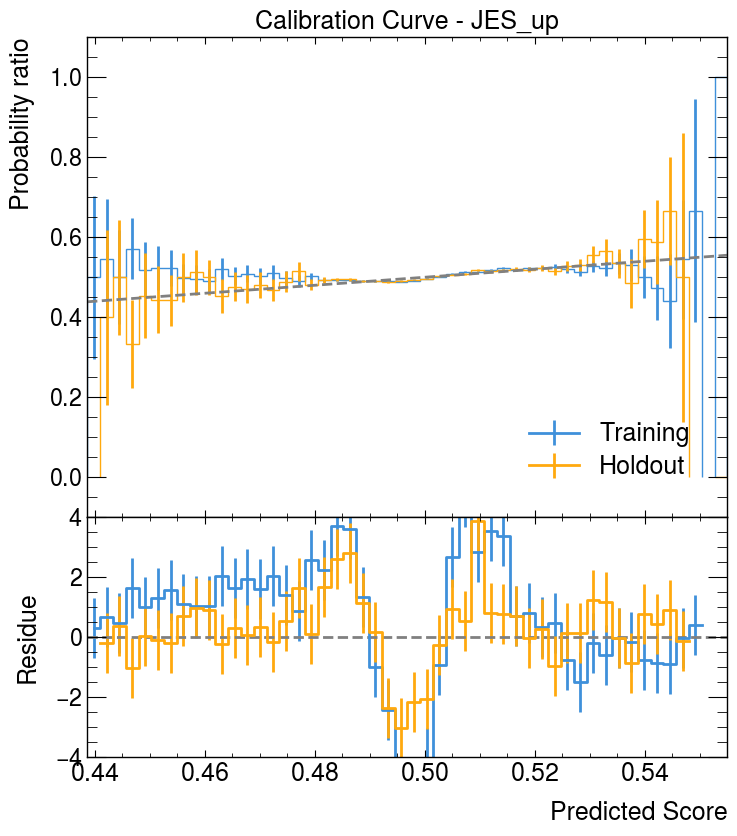

<Figure size 800x600 with 0 Axes>

In [13]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["JES"]["up"].make_calib_plots(nbins=num_bins_cal, observable='score')


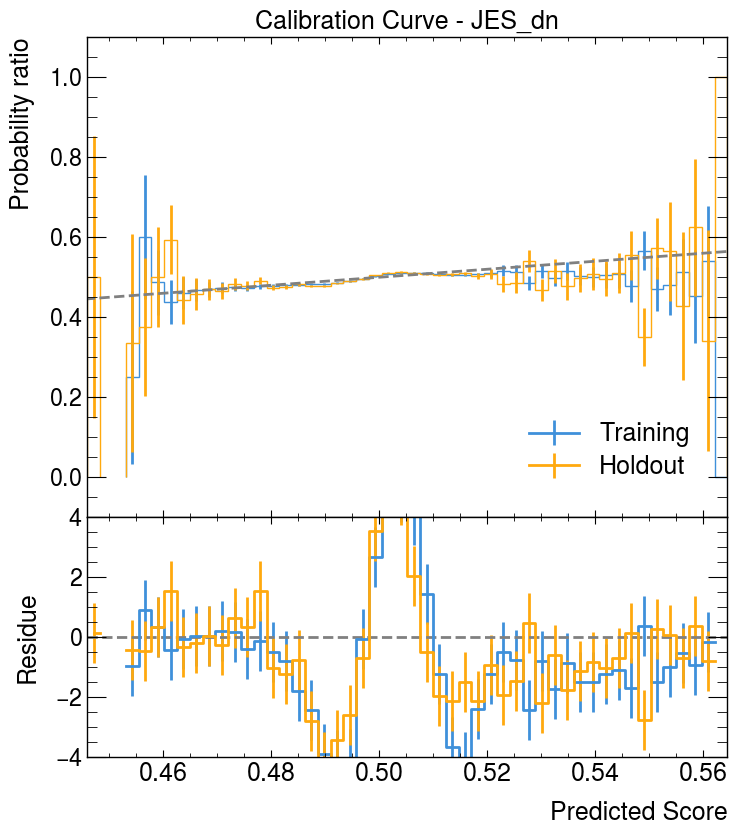

<Figure size 800x600 with 0 Axes>

In [14]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["JES"]["dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


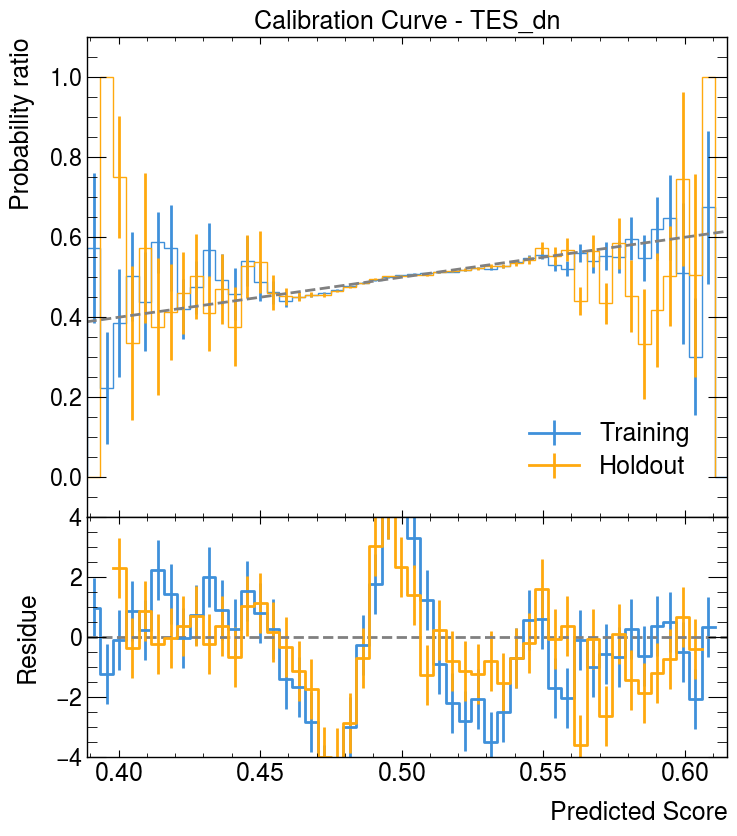

<Figure size 800x600 with 0 Axes>

In [15]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["TES"]["dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


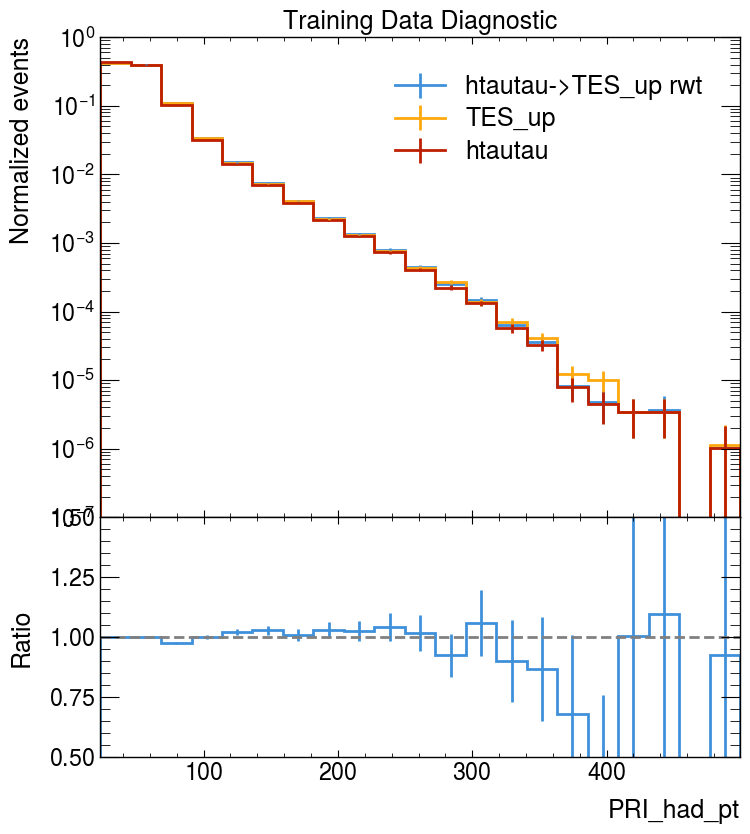

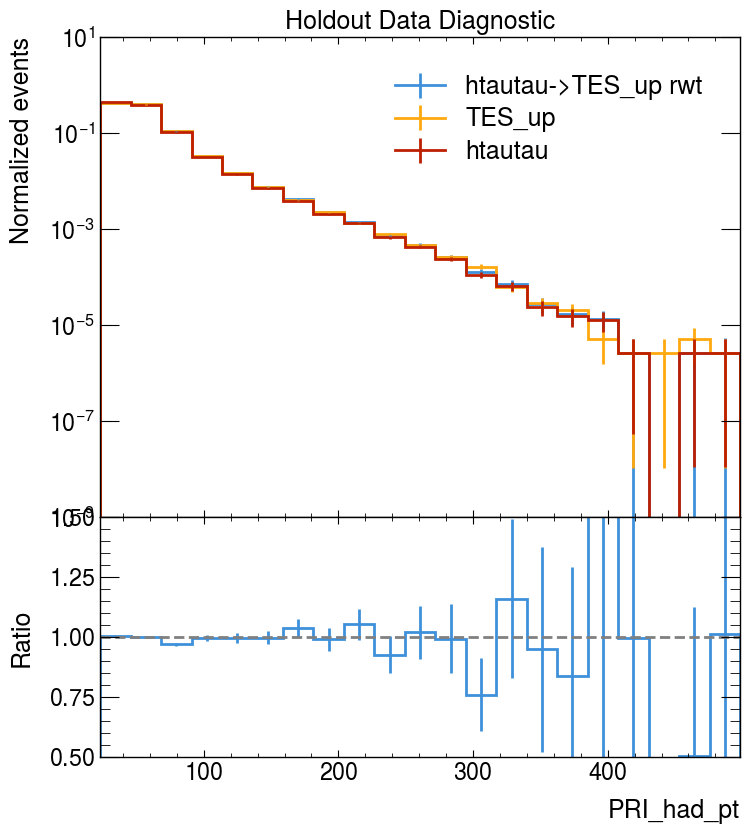

<Figure size 800x600 with 0 Axes>

In [16]:
variables_to_plot=['PRI_had_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["up"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


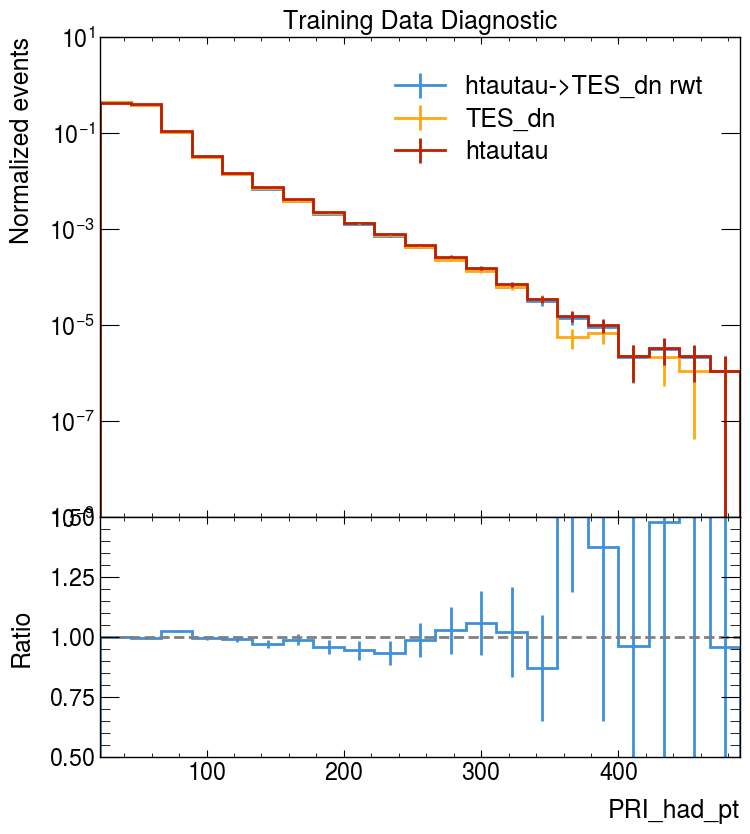

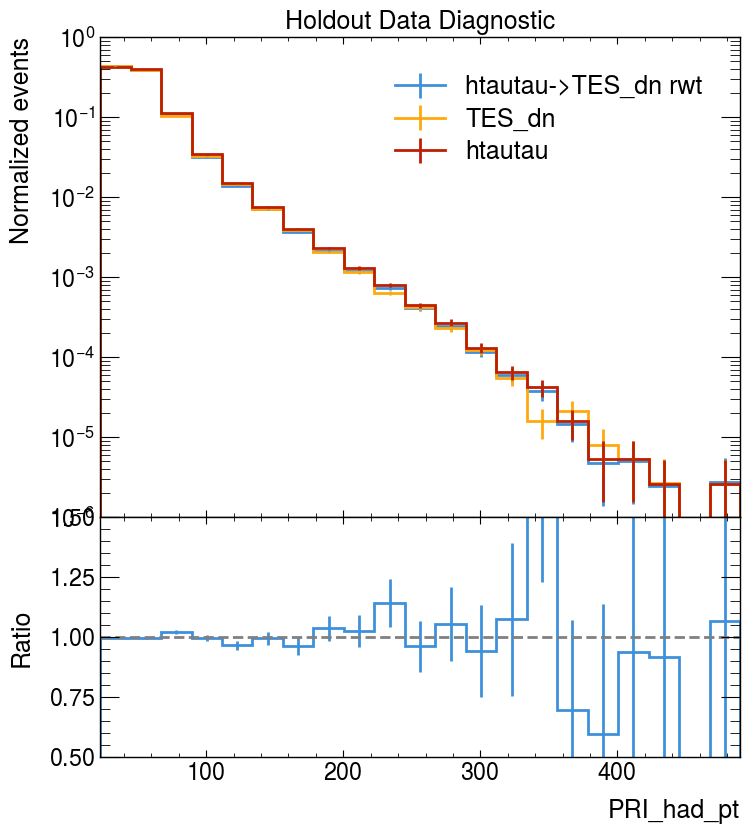

<Figure size 800x600 with 0 Axes>

In [17]:
variables_to_plot=['PRI_had_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["dn"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


Save the model output
--

Save the density ratios corresponding to each NP $\alpha_m$ and process $p_c(x)$ as a set of `numpy` arrays for use in the `Parameter_Fitting_with_Systematics.ipynb` notebook.

The trained models are also saved automatically by the training class for direct use in inference, or for evaluating on real data.

In [18]:
ensemble_aggregation_type = 'mean_ratio'

dataset_eval = pd.read_hdf(f"{saved_data}dataset_preselected_nominal_SR.h5", key="dataset", mode='r')

for process in labels_dict:
    
    for syst in dict_systs:

        if process not in dict_systs[syst]['process']:
            print(f"Nothing to evaluate for {process} in {syst} uncertainty")
            continue
        
        for direction in dict_systs[syst]['directions']:

            # Evaluate the density ratios p_alpha^\pm/p_nom for the nominal dataset
            NN_training_syst_process[process][syst][direction].evaluate_and_save_ratios(dataset_eval, aggregation_type = ensemble_aggregation_type)


Evaluating density ratios
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Density ratios saved
Evaluating density ratios
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Density ratios saved
Evaluating density ratios
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Density ratios saved
Evaluating density ratios
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Density ratios saved
Evaluating density ratios
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Density ratios saved
Evaluating density ratios
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Density ratios saved
Evaluating density ratios
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Density ratios saved
Evaluating density ratios
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Density ratios saved
Evaluating density ratios
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Density ratios saved
Evaluating density ratios
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Density ratios saved
Evaluating density ratios
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Density ratios saved
Evaluating density ratios
197/19

In [19]:
# Save the systematic variation on total yields in the SR
nu_var_SR = {}
for process in labels_dict:

    mask_process_nom = dataset_nom_channels['SR'].type==process
    nu_var_SR[process] = {}
    
    for syst in dict_systs:

        nu_var_SR[process][syst] = {}
        
        for direction in dict_systs[syst]['directions']:
            
            if process not in dict_systs[syst]['process']:
                nu_var_SR[process][syst][direction] = 1.0
            else:
                
                mask_process_syst = (datasets_syst_channels[syst][direction]['SR'].type==process)
                
                nu_var_SR[process][syst][direction] = datasets_syst_channels[syst][direction]['SR'][mask_process_syst].weights.sum() / dataset_nom_channels['SR'][mask_process_nom].weights.sum()
                if 'down' not in dict_systs[syst]['directions']:
                    nu_var_SR[process][syst]['down'] = 2.0 - nu_var_SR[process][syst]['up']
                    
                

In [20]:
# Save the Control Region variation histogram
with open(f"{saved_data}yield_SR_variations.pkl", "wb") as fp:
    pickle.dump(nu_var_SR, fp)